In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras import utils,models,layers,optimizers,callbacks
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
en_data = pd.read_csv("en_features.csv").fillna(0)
ar_data = pd.read_csv("ar_features.csv").fillna(0)

print(en_data.shape) #(48648, 2377)
print(ar_data.shape) #(2316, 2377)


print(en_data["labels"].unique()) # ['surprise', 'neutral', 'disgust', 'fear', 'sad', 'happy', 'angry']
print(ar_data["labels"].unique()) # ['happy', 'sad', 'angry', 'neutral']


(48648, 2377)
(2316, 2377)
['surprise' 'neutral' 'disgust' 'fear' 'sad' 'happy' 'angry']
['happy' 'sad' 'angry' 'neutral']


In [3]:
# Merge Datasets
combined_features = np.concatenate((en_data.drop(columns="labels"), ar_data.drop(columns="labels")))
combined_labels = np.concatenate((en_data["labels"], ar_data["labels"]))

unique_classes = np.unique(combined_labels)
num_classes = len(unique_classes)


In [4]:
print(pd.Series(combined_labels).value_counts())


angry       8292
sad         8280
happy       8220
neutral     8180
disgust     7692
fear        7692
surprise    2608
Name: count, dtype: int64


In [6]:
label_encoder = LabelEncoder()
combined_labels = utils.to_categorical(label_encoder.fit_transform(combined_labels))


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(combined_features, combined_labels, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# print(pd.Series(y_val).value_counts())
# print(pd.Series(y_test).value_counts())

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [9]:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [10]:
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [10]:
# Define metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
# Build the model
model = models.Sequential([
    layers.Conv1D(128, kernel_size=5, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5, strides=2, padding="same"),
    layers.Dropout(0.3),

    layers.Conv1D(128, kernel_size=5, strides=1, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5, strides=2, padding="same"),
    layers.Dropout(0.3),

    layers.Conv1D(64, kernel_size=3, strides=1, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=3, strides=2, padding="same"),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy", f1_m])

model.summary()

In [ ]:
# Training the model
EPOCHS = 50
BATCH_SIZE = 32

earlystopping = callbacks.EarlyStopping(monitor="val_accuracy", mode="auto", patience=5, restore_best_weights=True)
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/50
1275/1275 [==============================] - 55s 35ms/step - loss: 1.8732 - accuracy: 0.3226 - f1_m: 0.2246 - val_loss: 1.5136 - val_accuracy: 0.4082 - val_f1_m: 0.3024 - lr: 1.0000e-04
Epoch 2/50
1275/1275 [==============================] - 50s 39ms/step - loss: 1.5381 - accuracy: 0.4241 - f1_m: 0.3463 - val_loss: 1.3347 - val_accuracy: 0.4766 - val_f1_m: 0.3929 - lr: 1.0000e-04
Epoch 3/50
1275/1275 [==============================] - 44s 34ms/step - loss: 1.3629 - accuracy: 0.4792 - f1_m: 0.4194 - val_loss: 1.4261 - val_accuracy: 0.4827 - val_f1_m: 0.4187 - lr: 1.0000e-04
Epoch 4/50
1275/1275 [==============================] - 42s 33ms/step - loss: 1.2576 - accuracy: 0.5176 - f1_m: 0.4584 - val_loss: 1.4362 - val_accuracy: 0.5155 - val_f1_m: 0.4706 - lr: 1.0000e-04
Epoch 5/50
1275/1275 [==============================] - 41s 32ms/step - loss: 1.1741 - accuracy: 0.5495 - f1_m: 0.4935 - val_loss: 1.3418 - val_accuracy: 0.5434 - val_f1_m: 0.4973 - lr: 1.0000e-04
Epoch 6/50
1275

In [13]:
# Evaluate the model
test_accuracy = model.evaluate(X_test, y_test)[1] * 100
print(f"Accuracy of our model on test data: {test_accuracy:.2f}%")

160/160 [==============================] - 2s 11ms/step - loss: 0.1806 - accuracy: 0.9404 - f1_m: 0.9406
Accuracy of our model on test data: 94.04%


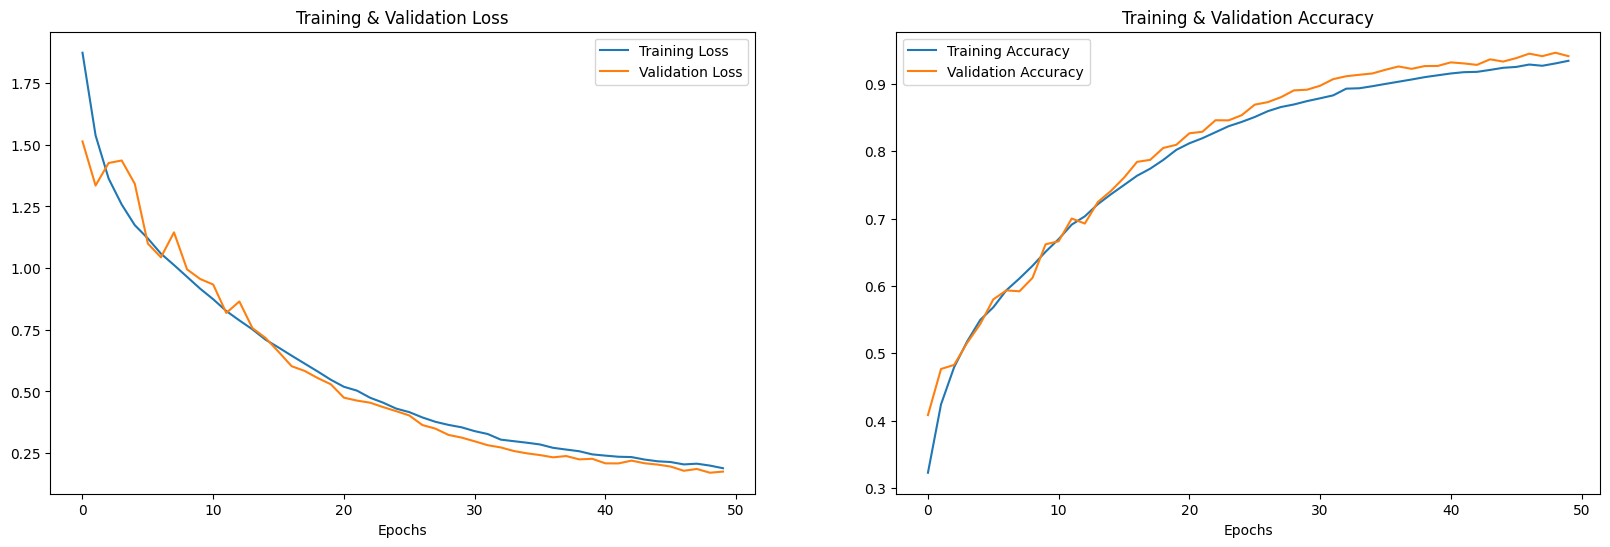

In [14]:
# Plotting training and testing loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()


160/160 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

       angry       0.94      0.95      0.95       790
         sad       0.94      0.93      0.93       794
       happy       0.93      0.93      0.93       747
     neutral       0.96      0.93      0.94       848
     disgust       0.94      0.95      0.94       841
        fear       0.92      0.97      0.94       793
    surprise       0.96      0.94      0.95       284

    accuracy                           0.94      5097
   macro avg       0.94      0.94      0.94      5097
weighted avg       0.94      0.94      0.94      5097



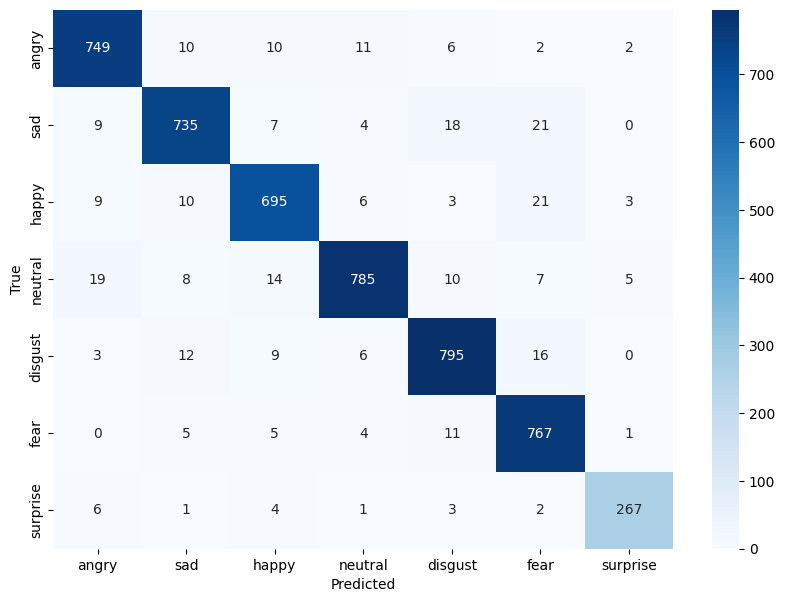

In [16]:
# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

emotion_labels = ['angry','sad','happy','neutral','disgust','fear','surprise']
# Classification report
cr = classification_report(y_true, y_pred, target_names=emotion_labels)


print(cr)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
# Save the model
model.save('en_ar_ser_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
